유튜브에서 공개한 주요 요인들을 보면,

View count  (many)

The rate of growth in views (급격하게)

Where views are coming from (including outside of YouTube)-(다양한 장소에서)

The age of the video (최신)

들이 있는데 최근에 급격하게 비디오 뷰가 상승하는 것이 트렌드 비디오가 되는 강력한 요인이 될것으로 가정할수 있다. 분석을 통해 이 가정이 옳은지 확인해보자.

In [ ]:
# Import our libraries we are going to use for our data analysis.
#import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

df = pd.read_csv('./US(subscriber).csv')
df_origin=df.copy()

us_videos_categories = pd.read_json('./US_category_id.json')
# Map Category IDs using the supporting file: US_category_id.json
categories = {int(category['id']): category['snippet']['title'] for category in us_videos_categories['items']}

In [ ]:
df.head(3)

In [ ]:
# data 기간
df_origin.trending_date

In [ ]:
df.info()

In [ ]:
# Category ID will be used to assign categories later, it is not a numeric variable.
df.category_id = df.category_id.astype('object')
df.info()

In [ ]:
df['category'] = [categories[cid] for cid in df.category_id]
df.drop('category_id',axis=1,inplace=True)
df.drop('topic',axis=1,inplace=True)
df

In [ ]:
total_num = df.isnull().sum().sort_values(ascending=False)

perc = df.isnull().sum()/df.isnull().count() *100
perc1 = (round(perc,2).sort_values(ascending=False))

# Creating a data frame:
df_miss = pd.concat([total_num, perc1], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)

In [ ]:
top_mis = df_miss[df_miss["Percentage %"]>0]
top_mis.reset_index(inplace=True)
top_mis

In [ ]:
df["description"] = df["description"].fillna(value="")

In [ ]:
# Summary of numeric Variables
pd.options.display.float_format = "{:.2f}".format #display float type
df.describe()

In [ ]:
# Summary of Numeric Variables
df.describe(percentiles=[.05,.25,.5,.75,.95]).round(1)

In [ ]:
# Summary of Object Variables
df.describe(include=[np.object])

In [ ]:
df.groupby('category').count().sort_values('views', ascending=False)

Clearly all categorical variables contain duplicates.
Row count is 40,949	 and unique values are < 7,000 for video_id, title, publich_time -- description.

In [ ]:
# 아이디 당 비디오 개수 확인. 즉 n 은 트렌트 비디오에 오른 횟수를 의미한다. 
df[df.video_id == "GgVmn66oK_A"]

In [ ]:
# All entries for top video_id's video
df[df.video_id == "j4KvrAUjn6c"]

In [ ]:
# Most Frequent Category, Entertainment is
df[df['category']== 'Entertainment']

In [ ]:
# Most Frequent Category, 24 is
print(categories[24])

In [ ]:
categories

In [ ]:
counter = 0
for k,v in categories.items():
    print('{:2d}: {:24}'.format(k,v),end=' ')
    counter += 1
    if counter % 4 == 0:
        print()
print('\n{} Categories in Total.'.format(counter))

In [ ]:
# Summary of Boolean Variables
df.select_dtypes(include=[np.bool]).apply(pd.Series.value_counts,dropna=False)

True Flags are exceptionally rare.
It is tempting to drop observations marked True in any of these variables.
The variable video_error_or_removed is the most promissing filter for data clean-up

#### Data prepocessing

In [ ]:
df

In [ ]:
# Transform trending_date to datetime date format

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%m/%d/%Y').dt.date
df.trending_date.value_counts().sort_index(inplace=True)
df.head()

In [ ]:
# Dataset is sorted by trending_date
pd.Index(df.trending_date).is_monotonic

In [ ]:
# Transforming publish_time to datetime
publish_time = pd.to_datetime(df.publish_time, format='%m/%d/%Y %H:%M')
# Create Variable publish_date
df['publish_date'] = publish_time.dt.date



In [ ]:
# Drop publish_time
df.drop('publish_time',axis=1,inplace=True)

In [ ]:
# Create New Variable Counting Days to Achieving Trending Status
df['days_to_trending'] = (df.trending_date - df.publish_date).dt.days

In [ ]:
df.days_to_trending.describe()

In [ ]:
#Create Meaningful Data Frame Index
df.set_index(['trending_date','video_id'],inplace=True)
df.head()

In [ ]:
# make like, dislike percentage
df['like_percentage'] = df['likes'] / (df['dislikes'] + df['likes'])
df['dislike_percentage'] = df['dislikes'] / (df['dislikes'] + df['likes'])
df.head()

In [ ]:
df['dislike_percentage'].describe()

In [ ]:
# let's show 'video_error_or_removed' == True
print(df[df.video_error_or_removed])

In [ ]:
# video_error_or_removed's dislike ratio
df[df.video_error_or_removed].dislike_percentage.describe()


how should we interpret 'video_error_or_removed' == True ?

By looking at dislike variable, We can see that 'video_error_or_removed' is true didn't mean the customer didn't like it.

But, looking at these two Deleted video video,

2018-02-02    kZete48ZtsY                                      Deleted video   
2018-02-03    kZete48ZtsY                                      Deleted video   

 
                              views   likes  dislikes  comment_count  \
trending_date video_id                                                 
2017-11-25    RK_B4Ez4_5Q   2618344   45197      2315           3332   
2018-02-01    kZete48ZtsY     60262    4804       122            736   
2018-02-02    kZete48ZtsY      2611       8        12              5   
2018-02-03    kZete48ZtsY      2620       8        12              5   

                         publish_date  days_to_trending  like_percentage  \
trending_date video_id                                                      
2017-11-25    RK_B4Ez4_5Q   2017-11-23                 2             0.95   
2018-02-01    kZete48ZtsY   2018-01-29                 3             0.98   
2018-02-02    kZete48ZtsY   2017-12-16                48             0.40   
2018-02-03    kZete48ZtsY   2017-12-16                49             0.40   

                           dislike_percentage  
trending_date video_id                         
2017-11-25    RK_B4Ez4_5Q                0.05  
2018-02-01    kZete48ZtsY                0.02  
2018-02-02    kZete48ZtsY                0.60  
2018-02-03    kZete48ZtsY                0.60  

we can see less view and comment, more dislikes than likes, longer days to be treding video.
We can assume the reasons for the removed.

In [ ]:
#Data Clean Up
#Drop Unreliable Observations
df = df[~df.video_error_or_removed]

In [ ]:
# Video Level Stats Using First Occurence Values (by view) :각 video_id의 처음 트렌딩에 뽑힌 비디오를 view 순으로
video_level = df.groupby(level=1).first()
video_level['freq'] = df['title'].groupby(level=1).count()
# video_level['category'] = [categories[cid] for cid in video_level.category_id]
# video_level.drop('category_id',axis=1,inplace=True)
video_level.sort_values(by=['views'],ascending=False,inplace=True)
video_level['views_ratio'] = round(df['views'].groupby(level=1).last() / video_level.views,2)
video_level['views_differ'] = round((df['views'].groupby(level=1).last() - video_level.views)/video_level['freq'])
views_min_dt = pd.Series([t[0] for t in df['views'].groupby(level=1).idxmin()],index=video_level.index)
video_level['views_min_dt'] = views_min_dt
video_level.head(10)

In [ ]:
# Video Level Stats Using first Occurence Values (by freq) :각 video_id의 처음 트렌딩에 뽑힌 비디오를 트렌드비디오 많이 된 순으로
video_level = df.groupby(level=1).first()
video_level['freq'] = df['title'].groupby(level=1).count()
# video_level['category'] = [categories[cid] for cid in video_level.category_id]
# video_level.drop('category_id',axis=1,inplace=True)
video_level.sort_values(by=['n'],ascending=False,inplace=True)
video_level['views_ratio'] = round(df['views'].groupby(level=1).last() / video_level.views,2)
video_level['views_differ'] = round((df['views'].groupby(level=1).last() - video_level.views)/video_level['freq'])
views_min_dt = pd.Series([t[0] for t in df['views'].groupby(level=1).idxmin()],index=video_level.index)
video_level['views_min_dt'] = views_min_dt
video_level.head(10)

#### Quick Stats for Top 10 Videos

In [ ]:
from IPython.display import HTML, display

# First Occurrence of the 10 Frequect videos on list and first views count
tmp = video_level.sort_values(by=['views','freq'],ascending=False).head(10)
#
# Construction of HTML table with miniature photos assigned to the most popular videos
table = '<h1>Top 10 Videos with high initial views and often selected for trends</h1><table>'

# Add Header
table += '<tr>'
table += '<th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th><th>Publish Date</th>'
table += '<th>Days Trending</th><th>Views</th><th>views_ratio</th><th>views_differ</th>'
table += '</tr>'

max_title_length = 50

for video_id, row in tmp.iterrows():
    table += '<tr>'
    table += '<td><img src="{thumbnail_link}" style="width:100px;height:100px;"></td>'.format(**row)
    table += '<td>{channel_title}</td>'.format(**row)
    table += '<td>{title}</td>'.format(**row)
    table += '<td>{category}</td>'.format(**row)
    table += '<td>{publish_date}</td>'.format(**row)
    table += '<td>{freq}</td>'.format(**row)
    table += '<td align="right">{views:11,d}</td>'.format(**row)
    table += '<td>{views_ratio:3}</td>'.format(**row)
    table += '<td>{views_differ:11}</td>'.format(**row)
    table += '</tr>'  
table += '</table>'

display(HTML(table))

#### Question: Are Video Trending Days Consecutive? Mostly True

In [ ]:
tmp = video_level[['n','freq','days_to_trending']]
days_to_trending_max = df.groupby(level=1)[['days_to_trending']].last()
tmp = tmp.join(days_to_trending_max,how='left',rsuffix='_max')
tmp['MaxContinuousDays'] = tmp.days_to_trending_max - tmp.days_to_trending + 1 
print('{:.2%}'.format(sum([a==b for a,b in zip(tmp.freq,tmp.MaxContinuousDays)]) / len(tmp.index)))
tmp[tmp.MaxContinuousDays != tmp.freq].head(20)

### What are the biggest Youtube channels?

In [ ]:
# top 25 channels for the highest number of videos

sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df.channel_title.value_counts()[:25]
_ = sns.barplot(y=tmp.index,x=tmp)

In [ ]:
df_c= df.groupby('channel_title')['subscribe'].median().sort_values (ascending=False).head(25)
df_c


In [ ]:
# top 20 channels for the highest number of subscribers

sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df_c[:25]
_ = sns.barplot(y=tmp.index,x=tmp)

First of all, I looked up for the top 20 channels which have the highest number of videos and subscribers. As you can see above, the two lists of the channels are different from each other. Most of the channels with lots of videos are for TV shows, broadcasts or organizations, like Tonight Show, Vox, The Ellen Show, and Netflix. On the other hand, those with lots of subscribers are music channels, like Ed Sheeran, Taylor Swift, Eminem, KatyPerry and Ariana Grande.

### What is the hottest topic on Youtube?
Let’s go deeper with topics this time. There are 16 types of topics and I counted the number of videos and channels for each topic. Which one is your favorite topic on Youtube? What are the hot and competitive topics?



In [ ]:
cat_df_us = df['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_us['index'],x=cat_df_us['category'], data=cat_df_us,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("The Number of trend videos in US per Topic")


In [ ]:
df['category'].value_counts()

In [ ]:
df['category']

In [ ]:
# df[['category','channel_title']].groupby('category').count().reset_index()


#### The Number of Channels in US per Topic

In [ ]:
 df[['channel_title','category']].groupby('category')['channel_title'].nunique().reset_index()

In [ ]:
cat_df_us2 = df[['channel_title','category']].groupby('category')['channel_title'].nunique().reset_index().sort_values(by='channel_title', ascending=False)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_us2['category'],x=cat_df_us2['channel_title'], data=cat_df_us2,orient='h')
plt.xlabel("Number of Channels")
plt.ylabel("Categories")
plt.title("The Number of Channels in US per Topic")

The distributions of the video and channel number show different patterns. Entertainment is at the top in both plots. Music, People & Blog, Howto & Style, and Science & Technology have a large number of channels. Can it be inferred that they are the most popular topics?

In [ ]:
# Most Infuential Creators(channels)
# top 50 channel
df['channel_title'].value_counts().head(50)

In [ ]:
df_2=df['category'].value_counts().reset_index()
df_2

In [ ]:
df_1=df[['channel_title','category']].groupby('category')['channel_title'].nunique().reset_index()
df_1.rename(columns={"category":"index"}, inplace = True)
df_1

In [ ]:
df_3=pd.merge(df_1, df_2)
df_3

In [ ]:
#df['category'].value_counts().reset_index().sort_values(by='index')['category']
#df[['channel_title','category']].groupby('category')['channel_title'].nunique().reset_index().sort_values(by='category')['channel_title']
#df['category'].value_counts().reset_index().sort_values(by='index')['category']/ df[['channel_title','category']].groupby('category')['channel_title'].nunique().reset_index().sort_values(by='category')['channel_title']


In [ ]:
# 각 케테고리 마다 경쟁률 (1: X)
df_3['competition_rate']=df_3['category']/df_3['channel_title']
df_3=df_3.sort_values(by='competition_rate',ascending=False)
df_3

In [ ]:
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=df_3['index'],x=df_3['competition_rate'], data=df_3,orient='h')
plt.xlabel("competition_rate (1:x)")
plt.ylabel("Categories")
plt.title("The competition_rate in US per Topic")

The plot with the number of videos and channels can tell you which topic has many competitors. The more channels a topic has, the more competitions there are in order to get an attention from people. On the other hand, the plots showing the number of videos or views can tell you which topic is the hottest. They can tell you what are the main interests of people.

신규 유튜버의 비디오가 트렌드 비디오에 올라기기 위해선 경쟁력이 낮은 토픽에 진입하는것을 추천한다.
뒤에서 어떤 요인이 트렌드 비디오를 만드는지 분석할것이다.

### count the median number of subscribe, views, likes, dislikes, and comments for each topic.

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df.groupby('category')['subscribe'].median().sort_values (ascending=False).head(25)
_ = sns.barplot(y=tmp.index,x=tmp)

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df.groupby('category')['views'].median().sort_values (ascending=False).head(25)
_ = sns.barplot(y=tmp.index,x=tmp)

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df.groupby('category')['likes'].median().sort_values (ascending=False).head(25)
_ = sns.barplot(y=tmp.index,x=tmp)

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df.groupby('category')['dislikes'].median().sort_values (ascending=False).head(25)
_ = sns.barplot(y=tmp.index,x=tmp)

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = df.groupby('category')['comment_count'].median().sort_values (ascending=False).head(25)
_ = sns.barplot(y=tmp.index,x=tmp)

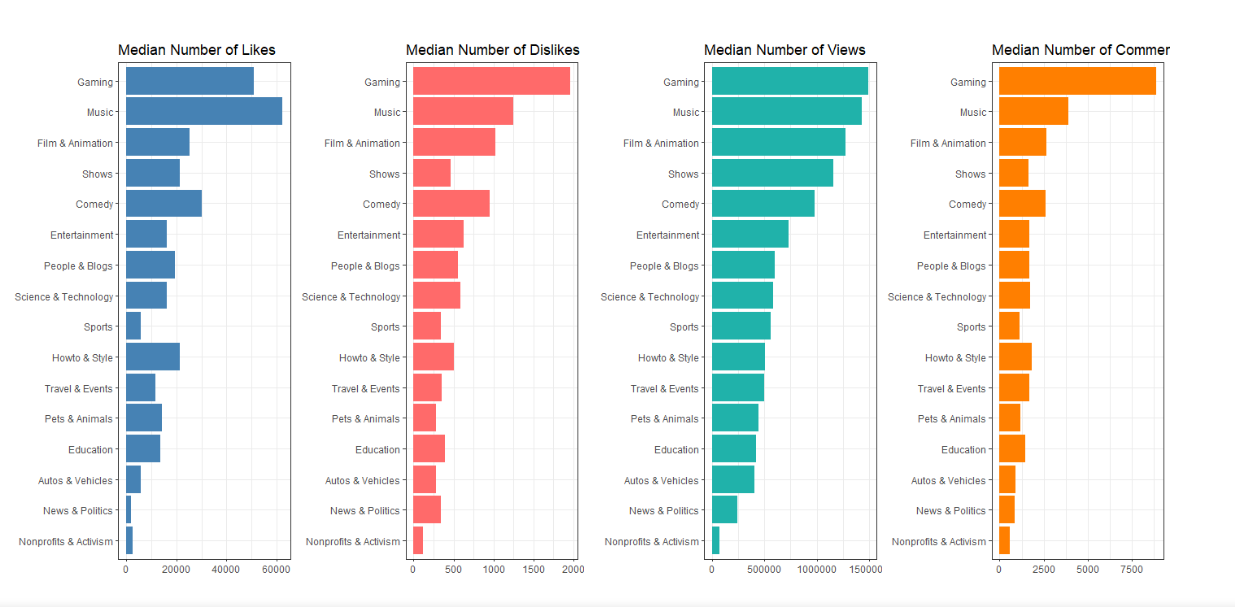

counted the median number of likes, dislikes, views, and comments for each topic. The order of topics on the y-axis is all same again, so you can easily compare the four counts. 

The plots of likes, dislikes and comments count show a similar distribution. Interestingly, Gaming is the hottest channel considering it has a relatively small number of channels and videos at the previous plot.

You can also find the response level of users with likes and dislikes, comment counts for each topic. For example, Entertainment or People & Blog are at the high rank for the number of videos and subscribers, but the response rate of them is lower than expected.

#### What about the time response?
The response rate can be also said in view of a time period. How long does it take to be a trending video? The subscribers for each topic will have different promptness and activeness so we can expect different patterns in time analysis.

In [ ]:
df

In [ ]:
import plotly.offline as py 
import plotly.figure_factory as ff 
import plotly.graph_objs as go 
from plotly import tools 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot 
py.init_notebook_mode(connected= True)


data1= []
for i in df["category"].unique():
    data1.append(go.Box(y = df[(df["category"]==i)&(df["days_to_trending"]<20)]["days_to_trending"], name = i)) # 조건 2개
    
layout = go.Layout(title = 'Days To Be Trending', 
                   xaxis = dict(title = 'topic'), 
                   yaxis = dict(title = 'days'))
fig = dict(data = data1, layout = layout)
py.iplot(fig)

In [ ]:
data2= []
for i in df["category"].unique():
    data2.append(go.Box(y = df[(df["category"]==i)&(df["days_to_trending"]<2)]["subscribe"], name = i)) # 조건 2개
    
layout = go.Layout(title = 'the subscriber numbers of trendy videos by topic (be trendy within a day)', 
                   xaxis = dict(title = 'topic'), 
                   yaxis = dict(title = 'number of subscribe'))
fig = dict(data = data2, layout = layout)
py.iplot(fig)

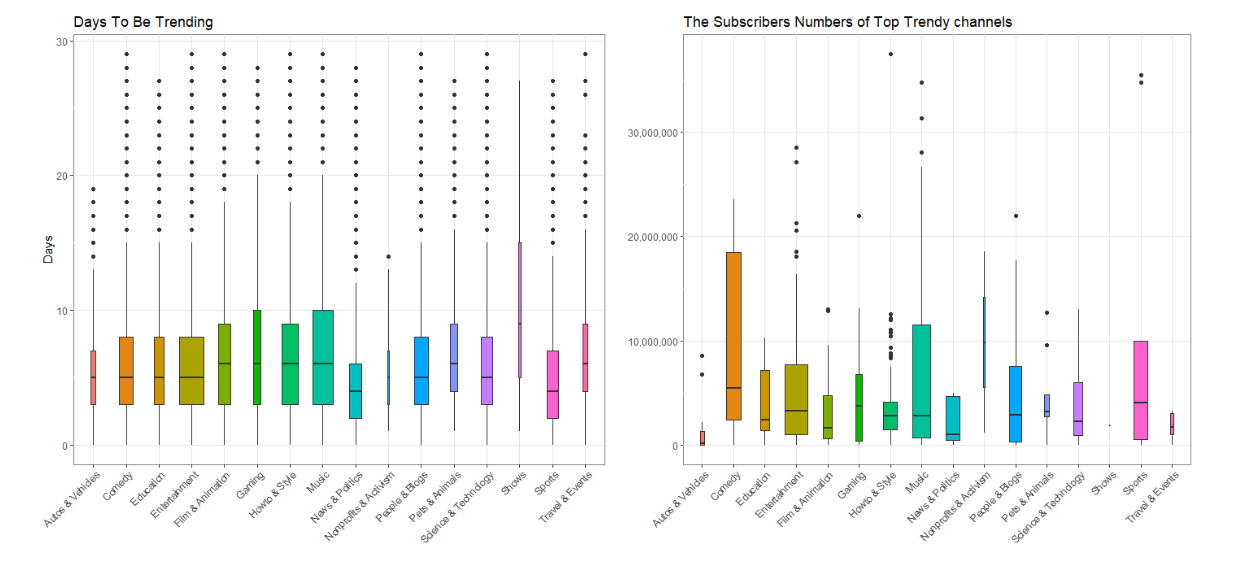


The plot on the left shows the number of days needs to be trendy for each topic. Most topics have similar distribution but News & Politics and Sports have the shortest whereas shows has the largest range of the period. The plot on the right shows the subscriber number of videos which get trendy in a day. We can easily expect that it will require lots of subscribers to be trendy in a day, however, it comes out with a broad range of the values. This could be inferred that subscriber numbers are not an absolute factor for the views.

The size of the boxes here indicates the size of the data. Therefore the Shows whose videos got attention in the day are few in our data, whereas trendy Entertainment or Music videos are a lot. This can be perceived more easily with the bar plot below. The video numbers being trendy in a day are shown and this is exactly the same with what the size of the box is telling us.



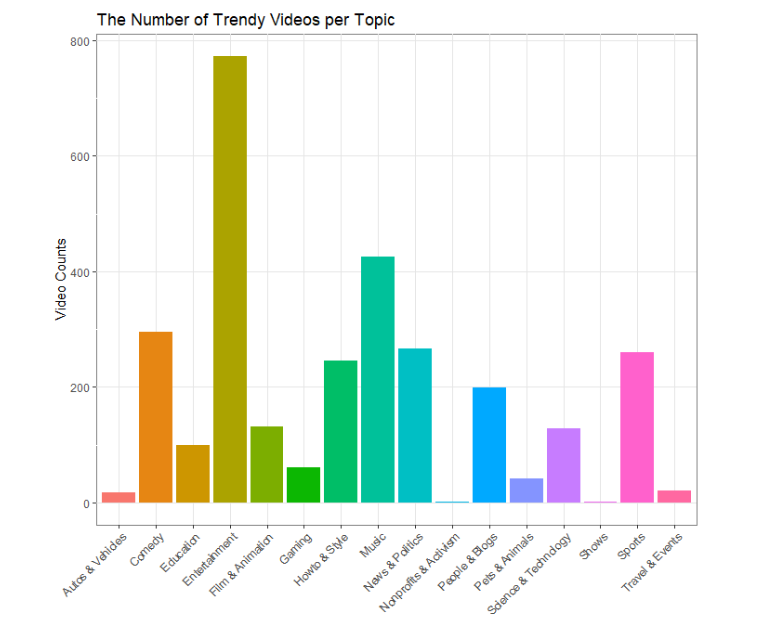

As a conclusion, the reaction rate of videos is different among topics. We can say that people who enjoy watching Gaming show their opinion and response actively. Videos conveying up-to-date news like News & Politics and Sports have a short period of time. Entertainment and Music keep appearing at the top of the list so far. But remember. Lots of popularity, lots of competitors.

### What title is suggested to get an attention?
There is a limitation in our perception when we give a glimpse to text. So the length of the title and the number of words in titles are important factors for eye-catching. Does the title length have an effect on the views? How many words are adequate to be contained in titles? Let’s check the answers from below.

In [ ]:
# word = "공백을 제외한 " \
#        "글자수만을 세는 코드 테스트"

# print(len([i for i in word if i != ' ']))

In [ ]:
data = []
for i in range(len(df['title'])):
    print(len(df['title'][i]))
    a = len(df['title'][i])
    data.append(a)

In [ ]:
df['len_title']=data


In [ ]:
data_n = []
data_w = []
for i in range(len(df['title'])): #한 row씩
        
        a = df['title'][i].split() #한행씩 단어를 담는다.
        data_n.append(a)
        
        b=sum(not word.isdigit() for word in df['title'][i].split())#한행씩 단어의 개수를 담는다
        
        data_w.append(b)
        

In [ ]:
df['nword_title']= data_w
df['len_title']=df['len_title']-df['nword_title']+1 # 전체 길이에서 단어간 공백 제거하여 진짜 글자수만 뽑는다
df

In [ ]:
# title length

plt.figure(figsize=(12,6))

plt.subplot(121)
g = sns.distplot(df["len_title"])
g.set_xlabel("", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Frequency Distribuition", fontsize=20)

plt.subplot(122)
g1 = sns.violinplot(y="len_title", data=df, 
               inner="quartile", palette="hls")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Amount Dist", fontsize=12)
g1.set_title("Amount Distribuition", fontsize=20)

plt.show()

In [ ]:
# title word count

plt.figure(figsize=(12,6))

plt.subplot(121)
g = sns.distplot(df["nword_title"])
g.set_xlabel("", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Frequency Distribuition", fontsize=20)

plt.subplot(122)
g1 = sns.violinplot(y="nword_title", data=df, 
               inner="quartile", palette="hls")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Amount Dist", fontsize=12)
g1.set_title("Amount Distribuition", fontsize=20)

plt.show()

In [ ]:
# title length 와 views 관계

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 20))
sns.jointplot(x = df.len_title, y = df.views, data = df, kind = 'scatter', height = 10, xlim=(0,150))
plt.show()

In [ ]:
# word count of the title 와 views 관계

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 20))
sns.jointplot(x = df.nword_title, y = df.views, data = df, kind = 'scatter', height = 10, xlim=(0,30))
plt.show()

The titles of the videos have less than 100 characters and the views get the highest around 30 and 50 characters. If we say a single word commonly has 5 or 6 characters, this means 5 to 10 words are preferable in the title. This goes align with the second plot. The number of words is less than 20 and the views are highest at around 8. Therefore a title with 7 to 8 words is appropriate to get more views.

In [ ]:
from collections import Counter
wordDict = Counter()


for i in range(len(df['title'])): #한 row씩
    for word in df['title'][i].split(): #한 문장에 들어있는 한 단어씩
        wordDict[word] += 1 #Counter에 count를 1씩 증가시킨다.     
       

In [ ]:
ignore = ['the','a','if','in','it','of','or','The','A','&','-','to','_','and','is','On','in','You','I','|','How','with','To']
for igword in ignore:
    if igword in wordDict:
        del wordDict[igword]

In [ ]:
wordDict

In [ ]:
wordDict.most_common(50)

In [ ]:
# video, Trailer, official,music, game,show ,star, black, movie, makeup, Teaser...

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud()

wc = WordCloud().generate_from_frequencies(wordDict)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df.columns

### Do the more tags really mean getting more views?
Tagging is an important factor of course. But how many tags should we use? Is it really true that the more tags bring more views?

In [ ]:
# number of tags 와 views 관계

plt.figure(figsize = (30, 20))
sns.jointplot(x = df['n_tags'], y = df.views, data = df, kind = 'scatter', height = 10, xlim=(0,70))
plt.show()

In [ ]:
df['n_tags'].describe()

In [ ]:
# the number of tags per topic

data3= []

for i in df["category"].unique():
    data3.append(go.Box(y = df[(df["category"]==i)&(df["days_to_trending"]<20)]['n_tags'], name = i)) # 조건 2개
    
layout = go.Layout(title = 'the tags numbers of trendy videos by topic', 
                   xaxis = dict(title = 'topic'), 
                   yaxis = dict(title = 'number of tags'))
fig = dict(data = data3, layout = layout)
py.iplot(fig)

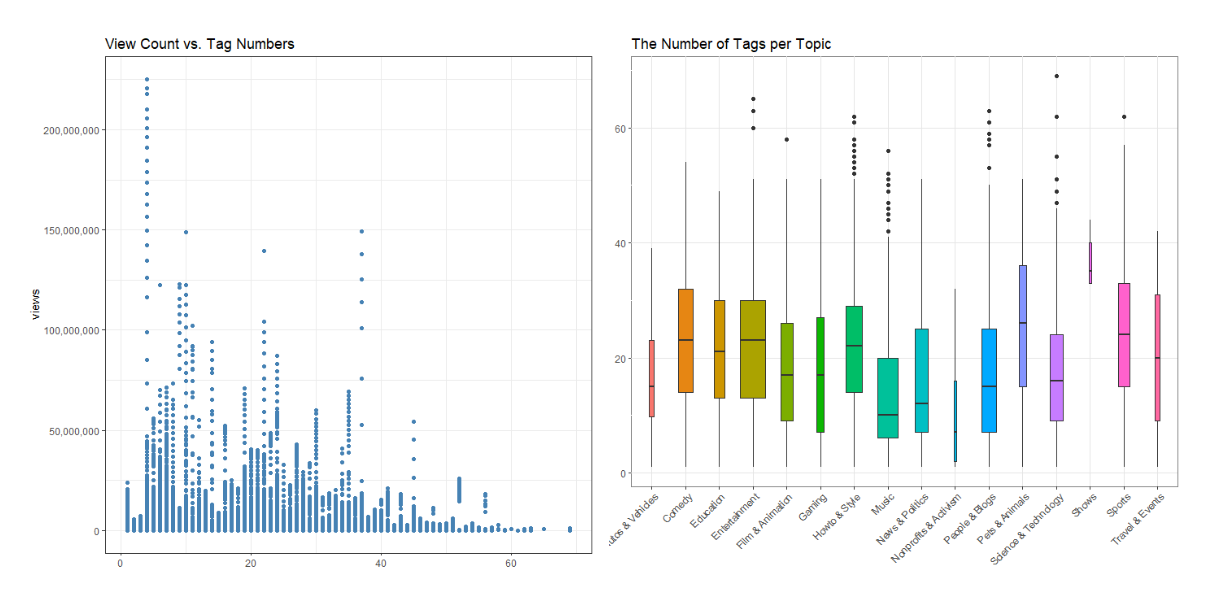

As shown, the number of tags doesn’t seem to be directly related to the views. The highest number of views is at 4 but there is no apparent tendency through the numbers. Additionally, with the right plot, we can see that they have different distributions for each topic. This indicates that it’s more about what keywords you have in your tag, not about how many you have.

#### Tag wordcloud per topic

In [ ]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 상위 25% views video 의 태그에 자주 사용된 단어들을 보자.

df_t=df[["views", "n_tags", "tags","category"]]
df_t= df_t[df_t["views"]>=1823349] 
df_t

In [ ]:
# Groupby by country
tag = df_t.groupby("category")

# Summary statistic of all countries
tag.describe()

In [ ]:
tag.mean().sort_values(by="n_tags",ascending=False)

In [ ]:
# 토픽 당 상위 25% 비디오의 수

plt.figure(figsize=(15,10))
tag.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Topic")
plt.ylabel("Number of vidios")
plt.show()

전체 비디오의 수는 Entertainment가 많지만 views가 높은 상위 25%의 비디오를 보면 music 이 가장 많은것을 알수있다.

In [ ]:
# Average Number of Tags of Video per Topic

plt.figure(figsize=(15,10))
tag.mean().sort_values(by="n_tags",ascending=False)["n_tags"].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Topic")
plt.ylabel("Average Number of Tags of Video")
plt.show()

In [ ]:
# Start with one review:
text = df_t.tags[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=100, max_words=10, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [ ]:
text = " ".join(tag for tag in df_t.tags.unique())
print ("There are {} words in the combination of all tag word.".format(len(text)))

In [ ]:
# wordcloud in all topic 

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The most visible tag words in the top 25 percent video are new, Movie, Music, Video, Trailer, Game, etc.
It seems like 'new, movie, music, video, trailer, and game' are the most mentioned characteristics, and 'new' is the most popular of them all. This aligns with the fact that 'new' is best represents the trend. 
it is also consistent with the fact that there are many top trend videos in music and entertainment.

In [ ]:
# Words used in popular video tags by topic

In [ ]:
tag.size().sort_values(ascending=False).head(10)

In [ ]:
# Join all reviews of each country:
mus = " ".join(tag for tag in df_t[df_t["category"]=="Music"].tags)
ent = " ".join(tag for tag in df_t[df_t["category"]=="Entertainment"].tags)
fil = " ".join(tag for tag in df_t[df_t["category"]=="Film & Animation"].tags)
com = " ".join(tag for tag in df_t[df_t["category"]=="Comedy"].tags)
peo = " ".join(tag for tag in df_t[df_t["category"]=="People & Blogs"].tags)
sty = " ".join(tag for tag in df_t[df_t["category"]=="Howto & Style"].tags)
spo = " ".join(tag for tag in df_t[df_t["category"]=="Sports"].tags)
sci = " ".join(tag for tag in df_t[df_t["category"]=="Science & Technology"].tags)
gam = " ".join(tag for tag in df_t[df_t["category"]=="Gaming"].tags)
new = " ".join(tag for tag in df_t[df_t["category"]=="News & Politics"].tags)

In [ ]:

wordcloud_mus = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=40).generate(mus)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_mus, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_fil = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=40).generate(fil)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_fil, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_com = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=30).generate(com)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_com, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_peo = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=30).generate(peo)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_peo, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_sty = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=30).generate(sty)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_sty, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_spo = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=30).generate(spo)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_spo, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_sci = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=30).generate(sci)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_sci, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_gam = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA",max_words=30).generate(gam)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_gam, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
wordcloud_new = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=30).generate(new)

plt.figure(figsize=[7,7])
plt.imshow(wordcloud_new, interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/us_wine.png", format="png")

plt.show()

In [ ]:
# graphic wordcloud

In [ ]:
youtube = np.array(Image.open("youtube.jpg"))


The way the masking functions works is that it requires all white part of the mask should be 255 not 0 (integer type). This value represents the "intensity" of the pixel. Values of 255 are pure white, whereas values of 1 are black. Here, you can use the provided function below to transform your mask if your mask has the same format as above. Notice if you have a mask that the background is not 0, but 1 or 2, adjust the function to match your mask.

First, you use the transform_format() function to swap number 0 to 255.


In [ ]:
# def transform_format(val):
#     if val == 0:
#         return 255
#     else:
#         return val

Then, create a new mask with the same shape as the mask you have in hand and apply the function transform_format() to each value in each row of the previous mask.

In [ ]:
# # Transform your mask into a new one that will work with the function:
# transformed_youtube = np.ndarray((youtube.shape[0],youtube.shape[1]), np.int32)

# for i in range(len(youtube)):
#     transformed_youtube[i] = list(map(transform_format, youtube[i]))

In [ ]:
# # Check the expected result of your mask
# transformed_youtube

In [ ]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=55, mask= youtube,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# # store to file
# wc.to_file("youtube.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

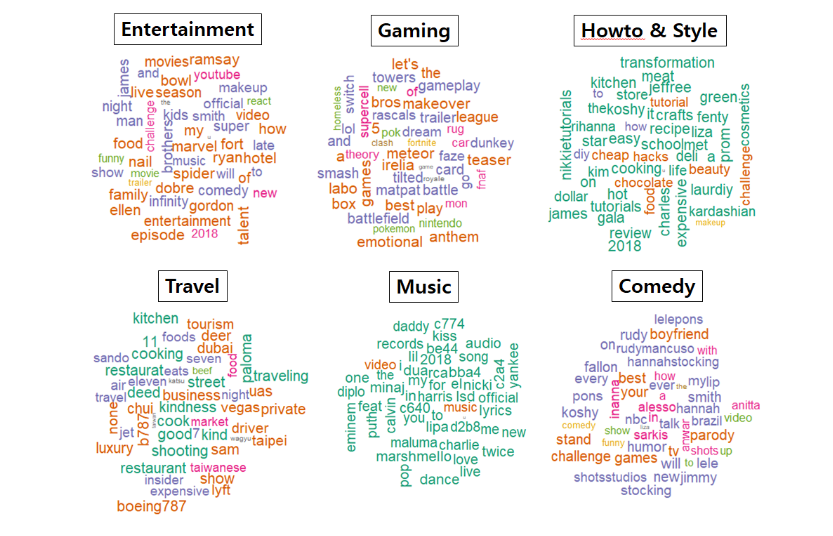

The word cloud shows what are the frequently used tags in the topics. These are from the videos which have more than 1.8 million views, which is a 3rd quantile of the total views. Although it can’t be said those views are due to the tags, at least we can infer what people are interested in and what to have in content.

In [ ]:
# 이미지 만들고 이미지 안에  wordcloud 그리기

# # Generate a word cloud image
# youtube = np.array(Image.open("youtube.jpg"))
# wordcloud_new = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=100, mask= youtube,).generate(new)

# # create coloring from image
# image_colors = ImageColorGenerator(youtube)
# plt.figure(figsize=[7,7])
# plt.imshow(wordcloud_new.recolor(color_func=image_colors), interpolation="bilinear")
# plt.axis("off")
# # # store to file
# # plt.savefig("img/us_wine.png", format="png")

# plt.show()

In [ ]:
df.info()

In [ ]:
df= df.drop('comments_disabled', axis = 1)
df= df.drop('ratings_disabled', axis = 1)
df= df.drop('video_error_or_removed', axis = 1)

In [ ]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
# quantitative.remove('views')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [ ]:
# quantitative data
f = pd.melt(df, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [ ]:
# 이 분석에서 의미가 없기에 unique가 너무 많은 변수는 삭제한다.
# Summary of Object Variables
df.describe(include=[np.object])

In [ ]:
qualitative.remove('channel_title')
qualitative.remove('title')
qualitative.remove('tags')
qualitative.remove('thumbnail_link')
qualitative.remove('description')
qualitative.remove('channel_id')
qualitative.remove('publish_date')

In [ ]:
# ylim을 정하자.
df.views.describe()

In [ ]:
for c in qualitative:
    df[c] = df[c].astype('category')
    if df[c].isnull().any():
        df[c] = df[c].cat.add_categories(['MISSING'])
        df[c] = df[c].fillna('MISSING')
        # null -> missing 카데고리를 만든다

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(df, id_vars=['views'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=15, ylim=(0, 10000000))
g = g.map(boxplot, "value", "views")

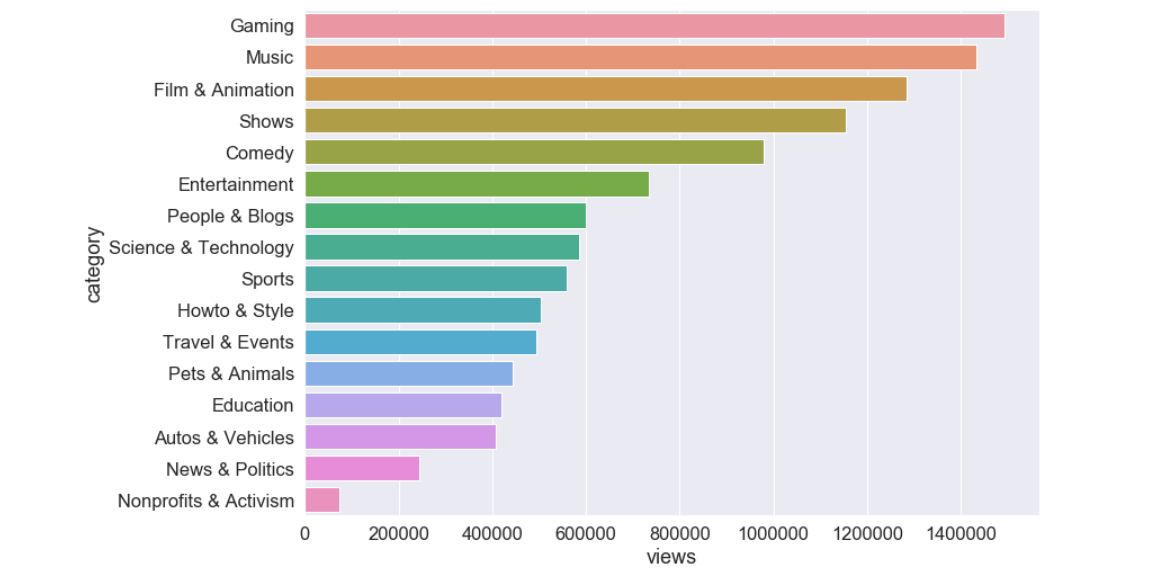

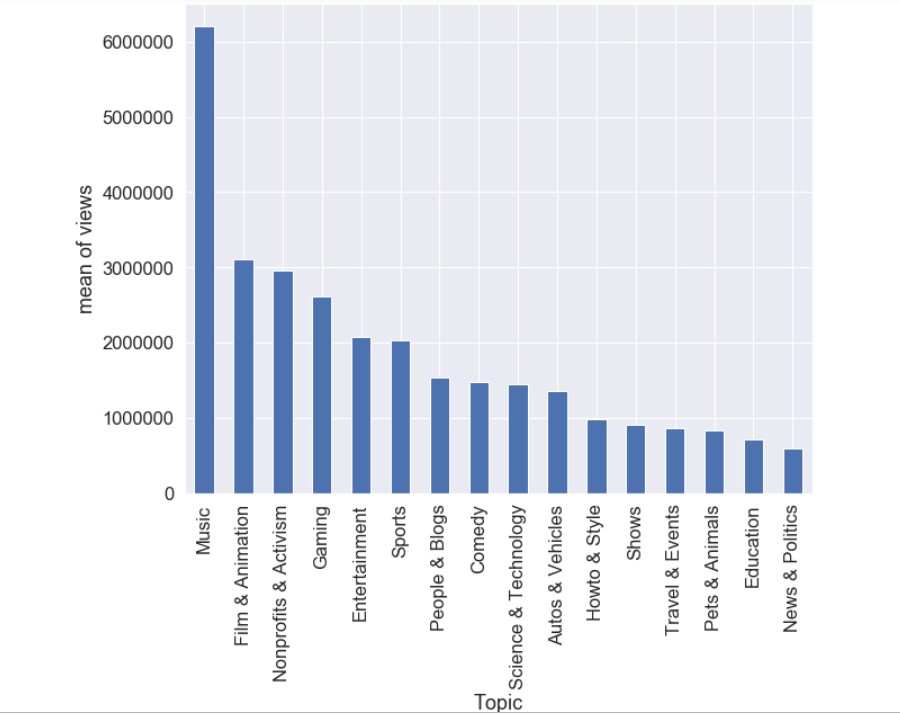

토픽 별로 views 중위값은 game 이 music 보다 높지만 범위 분포를 보면 music 의 범위가 넓은것을 알수있다. 소수 인기 뮤지션의 view가 압도적으로 높은걸을 알수있다. 토픽 별로 views의 평균을 보면 역시 music 이 압도적으로 값이 높은것을 볼수있는데 소수 인기 뮤지션이 평균을 끌어올렸음을 알수있다. 

In [ ]:
#질적변수(순서형+카테고리형)를 양적변수로 변화시키며 동시에 결측치도 의미있는 순서의 넘버를 받는다.

from scipy.stats import trim_mean
# m = stats.trim_mean(train[''], 0.1) # Trim 10% at both ends of the mean 극단치 제외하기위해 mean 대신 trim_mean 사용
    
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique() #각 특성의 카테고리값을 val에 넣었다
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'views']].groupby(feature)['views'].mean() #각 특성의 카테고리값의 SalePrice 평균을 spmean에 넣는다
    ordering = ordering.sort_values('spmean') # SalePrice 평균값이 작은 카테고리부터 sort된다.
    ordering['ordering'] = range(1, ordering.shape[0]+1) # 1부터 카데고리수만큼 순서를 정한후
    ordering = ordering['ordering'].to_dict() #딕셔너리 키밸류 셋으로 만든후
    
    for cat, o in ordering.items(): # 키,밸류 뽑아서
        frame.loc[frame[feature] == cat, feature+'_E'] = o # 카테고리 이름과 변수 이름이 만나는 행렬의 밸류값 즉 SalePrice평균값을 꺼낸다.
    
qual_encoded = []
for q in qualitative:  
    encode(df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

## Correlations

Generally to reduce confunding only variables uncorrelated with each other should be added to regression models (which are correlated with views).

In [ ]:
# 자기상관 없애기 위해
quantitative.remove('views')

In [ ]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['views'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(5, 0.5*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(df, features)

Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear.

The plot matrix with numeric features by using heatmap
made the plot matrix of all numeric variables. It has the number of subscribers, views, likes, dislikes, comments, the length of titles, the word numbers of titles, and the number of tags. You can easily check the scatter plot and correlation of all pairs. likes is correlated with views and comment counts. This plot matrix is very useful to see the overall relations among features before you start deeper analysis or to check the multi-collinearity before building a predictive model.

In [ ]:
#변수 그룹별 상관관계
#Correlation matrix

plt.figure(figsize=(10, 8)) 
plt.figure(1)
corr = df[quantitative+['views']].corr()
sns.heatmap(corr)

plt.figure(figsize=(10, 8))
plt.figure(2)
corr = df[qual_encoded+['views']].corr()
sns.heatmap(corr)

plt.figure(figsize=(10, 8))
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['views'], columns=qual_encoded+['views'])
for q1 in quantitative +['views']:
    for q2 in qual_encoded + ['views']:
        corr.loc[q1, q2] = df[q1].corr(df[q2])
sns.heatmap(corr)

In [ ]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(df, id_vars=['views'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(pairplot, "value", "views")

In [ ]:
# 인코딩한 데이터로 대체해서 df 새로 만듬

quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
# quantitative.remove('views')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

df_E=df[quantitative+qualitative]

In [ ]:
df_E.info()

In [ ]:
df.info()

In [ ]:
# category_E 의 의미는? 
df_c = df[["category", "category_E", "views"]]
df_c.sort_values(by=['category']).head()

In [ ]:
df_c.views.describe()

In [ ]:
# topic별로 views 평균을 보자
df_c.groupby("category").mean().sort_values(by=['views'])

In [ ]:
# topic별로 views 평균을 그래프로 보자

df_v=df_c.groupby("category")

plt.figure(figsize=(10,8))
df_v.mean().sort_values(by="views",ascending=False)['views'].plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("mean of views")
plt.show()

### The channel with more trendy video, the more views?
##### groupby 해서 그래프 그리기

n은 channel_title의 개수를 의미하므로 n으로 그룹을 묶고 그중에 views 가 가장 큰 비디오, 즉 가장 최신상태의 비디오를 골라 뷰를 확인한다. 나머진 같은 비디오의 중복이므로 필요없다.

In [ ]:
df

In [ ]:
num = df[["n", "views"]]

# Groupby by n
num = num.groupby("n")

# Summary statistic of all countries
num.describe().head()

In [ ]:
plt.figure(figsize=(35,10))
num.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Number of times selected for trend video")
plt.ylabel("Number of videos")
plt.show()

In [ ]:
plt.figure(figsize=(35,10))
num.max().sort_values(by="views",ascending=False)["views"].plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Number of times selected for trend video")
plt.ylabel("Number of views")
plt.show()

In [ ]:
#max of view

plt.figure(figsize=(35,10))
num.max().sort_values(by="n",ascending=True)["views"].plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Number of times selected for trend video")
plt.ylabel("Number of views")
plt.show()

In [ ]:
#mean of view
plt.figure(figsize=(35,10))
num.mean().sort_values(by="n",ascending=True)["views"].plot.bar()
plt.xticks(rotation=90)
plt.xlabel("Number of times selected for trend video")
plt.ylabel("Number of views")
plt.show()

트렌드 비디오를 5~7번 정도 가진 채널들이 가장 많다. 가장 많이 뽑힌 채널은 203개의 동영상이 뽑혔다. 그러나 25개의 비디오를 가진 채널이 가장 많은 views를 기록하였다. 관계를 보기쉽게 트렌드 비디오 횟수로 정렬을 해서 보면 두변수는 관계가 없는것을 볼수있다. 오히려 적은 트렌드 비디오를 가진 채널이 더 많은 view를 보여주고 있다. 트렌드 비디오 보유수당 뷰 평균으로 봐도 아무런 관계가 없는걸 볼수있다. 이것으로 보아 트렌드한 비디오를 많이 가지고 있는 채널일수록 뷰가 더 많은것이 아니란 것을 알수있다. 


In [ ]:
df.columns

### Relationship of Number of times selected for trend video and views 

In [ ]:
df_f=df[["title", "views","days_to_trending",'channel_title','thumbnail_link','category']]

In [ ]:
# Groupby by country
tit = df_f.groupby("title")

# Summary statistic of all countries
tit.describe()

In [ ]:
df_c=df_f.groupby(["title"]).size().reset_index(name='count')
df_c.head(5)

In [ ]:
# groupby 결과를 df 로 변환

df_tit= pd.DataFrame(tit.max().reset_index())
df_tit.head(5)

In [ ]:
df_mer= pd.merge(df_tit, df_c, how='left', on='title')
df_mer.head(5)

In [ ]:
# Number of times selected for trend video 와 views 관계

plt.figure(figsize = (30, 20))
sns.jointplot(x = df_mer['count'], y = df_mer['views'], data = df_mer, kind = 'scatter', height = 10, xlim=(0,30))
plt.show()

In [ ]:
# days_to_trending 와 views 관계
plt.figure(figsize = (30, 20))
sns.jointplot(x = df_mer['days_to_trending'], y = df_mer['views'], data = df_mer, kind = 'scatter', height = 10, xlim=(0,150))
plt.show()

Number of times selected for trend video 와 views의 관계는 소수의 비디오는 상관성을 보이나 전체적으로는 관계가 적다.
트렌드 비디오가 되는데 걸리는 시간을 보면 대부분 경우는 30일 이전에 몰려있다. 트렌드를 반영하기 위해서 비디오의 신선함은 아주 중요하다.


In [ ]:
# Video Level Stats Using first Occurence Values (by freq) 
video_f = tit.first()
video_f 

In [ ]:
# groupby 결과를 df 로 변환

v_f= pd.DataFrame(tit.first().reset_index())
v_f.head(5)

In [ ]:
v_f[['views_f','days_to_trending_f']]= v_f[['views','days_to_trending']]

v_f= v_f[['title','views_f','category','days_to_trending_f']]
v_f.head(5)

In [ ]:
df_mer= pd.merge(df_mer,v_f, how='left', on='title')
df_mer.head(5)

In [ ]:
# 최신과 최초의 veiw 차이를 보자.
df_mer['views_ratio'] = round(df_mer['views'] / df_mer['views_f'],2)
df_mer['views_differ'] = round((df_mer['views'] - df_mer['views_f'])/df_mer['count'])

df_mer.head(10)

In [ ]:
df_mer.columns

In [ ]:
from IPython.display import HTML, display

# First Occurrence of the 10 Frequect videos on list and first views count
tmp = df_mer.sort_values(by=['views'],ascending=False).head(10)
#
# Construction of HTML table with miniature photos assigned to the most popular videos
table = '<h1>Top 10 Videos with high views </h1><table>'

# Add Header
table += '<tr>'
table += '<th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th>'
table += '<th>treding count</th><th>Days to Trending</th><th>Views</th><th>views_ratio</th><th>views_differ</th>'
table += '</tr>'

max_title_length = 50

for video_id, row in tmp.iterrows():
    table += '<tr>'
    table += '<td><img src="{thumbnail_link}" style="width:100px;height:100px;"></td>'.format(**row)
    table += '<td>{channel_title}</td>'.format(**row)
    table += '<td>{title}</td>'.format(**row)
    table += '<td>{category}</td>'.format(**row)
    table += '<td>{count}</td>'.format(**row)
    table += '<td>{days_to_trending_f}</td>'.format(**row)
    table += '<td align="right">{views:11,d}</td>'.format(**row)
    table += '<td>{views_ratio:3}</td>'.format(**row)
    table += '<td>{views_differ:11}</td>'.format(**row)
    table += '</tr>'  
table += '</table>'

display(HTML(table))

In [ ]:
df_mer.sort_values(by=['views'],ascending=False).head(10).mean()

In [ ]:
df_mer

In [ ]:
from IPython.display import HTML, display

# First Occurrence of the 10 Frequect videos on list and first views count
tmp = df_mer.sort_values(by=['count'],ascending=False).head(10)
#
# Construction of HTML table with miniature photos assigned to the most popular videos
table = '<h1>Top 10 Videos with often selected for trends</h1><table>'

# Add Header
table += '<tr>'
table += '<th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th>'
table += '<th>treding count</th><th>Days to Trending</th><th>Views</th><th>views_ratio</th><th>views_differ</th>'
table += '</tr>'

max_title_length = 50

for video_id, row in tmp.iterrows():
    table += '<tr>'
    table += '<td><img src="{thumbnail_link}" style="width:100px;height:100px;"></td>'.format(**row)
    table += '<td>{channel_title}</td>'.format(**row)
    table += '<td>{title}</td>'.format(**row)
    table += '<td>{category}</td>'.format(**row)
    table += '<td>{count}</td>'.format(**row)
    table += '<td>{days_to_trending_f}</td>'.format(**row)
    table += '<td align="right">{views:11,d}</td>'.format(**row)
    table += '<td>{views_ratio:3}</td>'.format(**row)
    table += '<td>{views_differ:11}</td>'.format(**row)
    table += '</tr>'  
table += '</table>'

display(HTML(table))

In [ ]:
df_mer.sort_values(by=['count'],ascending=False).head(10).mean()

In [ ]:
from IPython.display import HTML, display

# First Occurrence of the 10 Frequect videos on list and first views count
tmp = df_mer.sort_values(by=['days_to_trending'],ascending=False).head(10)
#
# Construction of HTML table with miniature photos assigned to the most popular videos
table = '<h1>Top 10 video Remains in Long Trend Video</h1><table>'

# Add Header
table += '<tr>'
table += '<th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th>'
table += '<th>treding count</th><th>Days to Trending</th><th>Views</th><th>views_ratio</th><th>views_differ</th>'
table += '</tr>'

max_title_length = 50

for video_id, row in tmp.iterrows():
    table += '<tr>'
    table += '<td><img src="{thumbnail_link}" style="width:100px;height:100px;"></td>'.format(**row)
    table += '<td>{channel_title}</td>'.format(**row)
    table += '<td>{title}</td>'.format(**row)
    table += '<td>{category}</td>'.format(**row)
    table += '<td>{count}</td>'.format(**row)
    table += '<td>{days_to_trending_f}</td>'.format(**row)
    table += '<td align="right">{views:11,d}</td>'.format(**row)
    table += '<td>{views_ratio:3}</td>'.format(**row)
    table += '<td>{views_differ:11}</td>'.format(**row)
    table += '</tr>'  
table += '</table>'

display(HTML(table))

In [ ]:
df_mer.sort_values(by=['days_to_trending'],ascending=False).head(100).mean()

In [ ]:
from IPython.display import HTML, display

# First Occurrence of the 10 Frequect videos on list and first views count
tmp = df_mer.sort_values(by=['views_ratio'],ascending=False).head(10)
#
# Construction of HTML table with miniature photos assigned to the most popular videos
table = '<h1>Top 10 most Rapidly Growing Videos</h1><table>'

# Add Header
table += '<tr>'
table += '<th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th>'
table += '<th>treding count</th><th>Days to Trending</th><th>Views</th><th>views_ratio</th><th>views_differ</th>'
table += '</tr>'

max_title_length = 50

for video_id, row in tmp.iterrows():
    table += '<tr>'
    table += '<td><img src="{thumbnail_link}" style="width:100px;height:100px;"></td>'.format(**row)
    table += '<td>{channel_title}</td>'.format(**row)
    table += '<td>{title}</td>'.format(**row)
    table += '<td>{category}</td>'.format(**row)
    table += '<td>{count}</td>'.format(**row)
    table += '<td>{days_to_trending_f}</td>'.format(**row)
    table += '<td align="right">{views:11,d}</td>'.format(**row)
    table += '<td>{views_ratio:3}</td>'.format(**row)
    table += '<td>{views_differ:11}</td>'.format(**row)
    table += '</tr>'  
table += '</table>'

display(HTML(table))

In [ ]:
df_mer.sort_values(by=['views_ratio'],ascending=False).head(100).mean()

같은 비디오들의 유니크한 한값만 쓰기위해 title 이나 video_id로 그룹을 지어 최초(first)와 최신(last or max)로 두개의 테이블을 만들어 조인. days_to_trending은 최초 트렌드비디오가 된 기간을 사용하고 view는 최초와 최신의 비율을 보고 또,차이를 트렌드비디오가 된 횟수(count)로 나누어 간 간격간 평균차이를 보았다. 이 조건으로 view(얼마나 많이보는지), count(얼마나 빈번한지), days_to_trending(얼마나 오래 트렌드비디오로 남아있는지),views_ratio(얼마나 급격한게 성장했는지) 를 기준으로 sort하였다.

In [ ]:
df_mer

In [ ]:
df_mer.groupby('category')[['count','views_ratio']].max()

In [ ]:
df_mer.groupby('category')[['count','views_ratio']].mean()

In [ ]:
# view 의 성장속도와 트렌드 비디오 선정과의 관계.
plt.figure(figsize = (30, 20))
sns.jointplot(x = df_mer['count'], y = df_mer['views_ratio'], data = df, kind = 'scatter', height = 10, xlim=(0,70))
plt.show()

### Conclusion

Let me recap on what we’ve been walked through so far.

We analyzed a dataset that contains information about YouTube trending videos for 205 days. The dataset was collected in 2017 and 2018. It contains 40949 video entry.

The number of videos and subscribers can be applied to evaluating the hotness and competitiveness. When it’s considered with topics, Entertainment and Music are the most popular.

The response rate can be thought in two ways. When it’s considered with the number of likes, dislikes, and comments, Gaming is the hottest topic with highly active users. In the view of the time period, the channels delivering latest issues like News & Politics and Sports get the quickest response.

Title phrasing is important and 6 to 7 words are appropriate to get more views.

When it comes to tagging, including keywords is more important than just having many tags. Therefore knowing what are the main issues are required.

To be a successful youtuber, having thousands of subscribers is obviously significant. However, making videos that contains what people really care about is as much important as the subscriber numbers. Therefore it is required to have the ability to read what are the trends and what kind of needs people are having.


For further analysis, we can choose one specific topic and work on subtopics. It will give us more detailed information. Time series analysis with a channel is also possible. Researching the growth pattern of popular channels can be a good example. This kind of research can be used not only for youtubers but also for digital marketers. If they go further analysis with comments, they can withdraw an insight on how to target their customers.

In [ ]:
df

## Date modeling for Regression 

In [ ]:
df.columns

In [ ]:
df_model= df[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [ ]:
# views와 상관성이 높은 comment를 제외하고 'len_title' ,'nword_title'도 상관성이 높으니 'nword_title'만 사용하기로 하자.

In [ ]:
Label = df_model['views']
features = df_model[['n', 'subscribe','nword_title','n_tags','category_E','days_to_trending']]

In [ ]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(
    features, Label, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("train 세트의 크기: {}   validate 세트의 크기: {}   test 세트의 크기:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))


# X_train, y_train  //  X_valid, y_valid  //  X_test, y_test

In [ ]:
### 데이터 전처리 - 데이터 표준화 작업 (scaling)
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
transformer = sc.fit(X_train)
transformer


In [ ]:
#위에서 training set으로 fit 시킨 평균,분산 값을 이용하여 각 세트의 독립변수(X)들을 변환시킨다. 
X_train_std=transformer.transform(X_train)
X_valid_std=transformer.transform(X_valid)
X_test_std=transformer.transform(X_test)



### Model 
(이번 모델의 목적은 view에 가장 큰 영향을 끼치는 요인을 찾고 새로운 동영상의 미래 잠재 view을 예측하는것이다)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_std, y_train)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_valid_std, y_valid)))

In [ ]:
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(forest.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(random_state=42)
gbrt.fit(X_train_std, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_valid_std, y_valid)))

In [ ]:
gbrt = GradientBoostingRegressor(random_state=42, learning_rate=0.3,max_depth=3)
gbrt.fit(X_train_std, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_valid_std, y_valid)))

In [ ]:
gbrt = GradientBoostingRegressor(random_state=42, learning_rate=0.2)
gbrt.fit(X_train_std, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_valid_std, y_valid)))


In [ ]:
gbrt = GradientBoostingRegressor(random_state=42, learning_rate=0.3,max_depth=3) #best model 선택
gbrt.fit(X_train_std, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(gbrt.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [ ]:
# 최종 테스트 (위에서 가장 성능좋은것 실행후 하자 이름이 모두 gbrt로 같기 때문.)
print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test_std, y_test)))

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test_std, y_test)))

In [ ]:
# Get numerical feature importances

feature_list = list(X_train.columns)
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 80% of importance retained
plt.hlines(y = 0.80, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

주요변수 3개가 model 75%를 설명하는 것을 볼수있다
주요 변수를 바탕으로 views 에 끼치는 영향을 본다

In [ ]:
df.columns

In [ ]:
df_p=df[['subscribe','n_tags','days_to_trending','views']]
df_p.head()

In [ ]:
df_p.groupby(df_p.views).mean()


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# X_train_std, y_train

X = sm.add_constant(X_train_std) # adding a constant
Y= y_train

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

In [ ]:
X_train.head()

In [ ]:
#_=sns.pairplot(df_model)
sns.pairplot(df_model)
plt.title("df_model 의 Pair Plot")
plt.show()

## 데이터 분포를 변환시켜서 다시 분석.

### 데이터 분포 변환
대부분의 모델은 변수가 특정 분포를 따른다는 가정을 기반으로 한다. 예를 들어 선형 모델의 경우, 설명 및 종속변수 모두가 정규분포와 유사할 경우 성능이 높아지는 것으로 알려져 있다. 자주 쓰이는 방법은 Log, Exp, Sqrt 등 함수를 이용해 데이터 분포를 변환하는 것이다. 

밑에 방법 외에도 분포의 특성에 따라 제곱, 자연로그, 지수 등 다양한 함수가 사용될 수 있다. 가이드는 아래와 같다.

left_distribution: X^3
mild_left: X^2
mild_right: sqrt(X)
right: ln(X)
servere right: 1/X

In [ ]:
df_model= df[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [ ]:
import math
from sklearn import preprocessing

# 특정 변수에만 함수 적용
# df['X_log'] = preprocessing.scale(np.log(df['X']+1)) # 로그
# df['X_sqrt'] = preprocessing.scale(np.sqrt(df['X']+1)) # 제곱근

# # 데이터 프레임 전체에 함수 적용 (단, 숫자형 변수만 있어야 함)
# df_log = df_model.apply(lambda x: np.log(x+1))    

df_model['subscribe_log']= preprocessing.scale(np.log(df_model['subscribe']+1))
df_model['days_to_trending_log']= preprocessing.scale(np.log(df_model['days_to_trending']+1))
df_model['views_log']= preprocessing.scale(np.log(df_model['views']+1))

In [ ]:
df_model.drop('views',axis=1,inplace=True)
df_model.drop('subscribe',axis=1,inplace=True)
df_model.drop('days_to_trending',axis=1,inplace=True)

In [ ]:
#_=sns.pairplot(df_model)
# views, subscribe 변수를 로그전환 하였다
sns.pairplot(df_model)
plt.title("df_model 의 Pair Plot")
plt.show()

### 데이터 단위 변환
데이터의 스케일(측정단위)이 다를 경우 특히 거리를 기반으로 분류하는 모델(KNN 등)에 부정적인 영향을 미치므로, 스케일링을 통해 단위를 일정하게 맞추는 작업을 진행해야 한다. 아래 방식이 주로 스케일링을 위해 쓰이는 방법이다. 대부분의 통계 분석 방법이 정규성 가정을 기반으로 하므로 완벽하지 않더라도 최대한 정규분포로 변환하는 노력이 필요하다.

Scaling: 평균이 0, 분산이 1인 분포로 변환
MinMax Scaling: 특정 범위 (예, 0~1)로 모든 데이터를 변환
Box-Cox: 여러 k 값중 가장 작은 SSE 선택
Robust_scale: median, interquartile range 사용(outlier 영향 최소화)

In [ ]:
# from scipy.stats import boxcox

# # 변수별 scaling 적용
# df['X_scale'] = preprocessing.scale(df['X']) 
# df['X_minmax_scale'] = preprocessing.MinMaxScaler(df['X']
# df['X_boxcox'] = preprocessing.scale(boxcox(df['X']+1)[0])
# df['X_robust_scale'] = preprocessing.robust_scale(df['X'])

# # 데이터 프레임 전체에 scaling 적용
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# # StandardScaler
# for c in df:
#     df_sc[c] = StandardScaler().fit_transform(df[c].reshape(-1,1)).round(4)

# # MinMaxScaler
# for c in df:
#     df_minmax[c] = MinMaxScaler().fit_transform(df[c].reshape(-1,1).round(4))


In [ ]:
Label = df_model['views_log']
features = df_model[['n', 'subscribe_log','nword_title','n_tags','category_E','days_to_trending_log']]

In [ ]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(
    features, Label, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("train 세트의 크기: {}   validate 세트의 크기: {}   test 세트의 크기:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))


# X_train, y_train  //  X_valid, y_valid  //  X_test, y_test

In [ ]:
### 데이터 전처리 - 데이터 표준화 작업 (scaling)
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
transformer = sc.fit(X_train)
transformer


In [ ]:
#위에서 training set으로 fit 시킨 평균,분산 값을 이용하여 각 세트의 독립변수(X)들을 변환시킨다. 
X_train_std=transformer.transform(X_train)
X_valid_std=transformer.transform(X_valid)
X_test_std=transformer.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_std, y_train)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_valid_std, y_valid)))

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test_std, y_test)))

In [ ]:
# Get numerical feature importances

feature_list = list(X_train.columns)
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 70% of importance retained
plt.hlines(y = 0.70, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

주요변수 3개가 model 70%를 설명하는 것을 볼수있다 주요 변수를 바탕으로 views 에 끼치는 영향을 본다

In [ ]:
df_p=df[['subscribe','n','days_to_trending','views']]
df_p.head()

In [ ]:
df_p.groupby(df_p.views).mean()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# X_train_std, y_train

X = sm.add_constant(X_train_std) # adding a constant
Y= y_train

model = sm.OLS(Y, X).fit()

predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

In [ ]:
X_train.head()